# CIFAR10

In [1]:
%reset 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Colorization AutoEncoder
### EDA

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Color Image(RGB) -> Gray_Scale Image
# grayscale = 0.299*red + 0.587*green + 0.114*blue
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [4]:
# Data Loading
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
img_rows, img_cols, channels = x_train.shape[1:]

In [5]:
# Make saved_imgaes folders
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

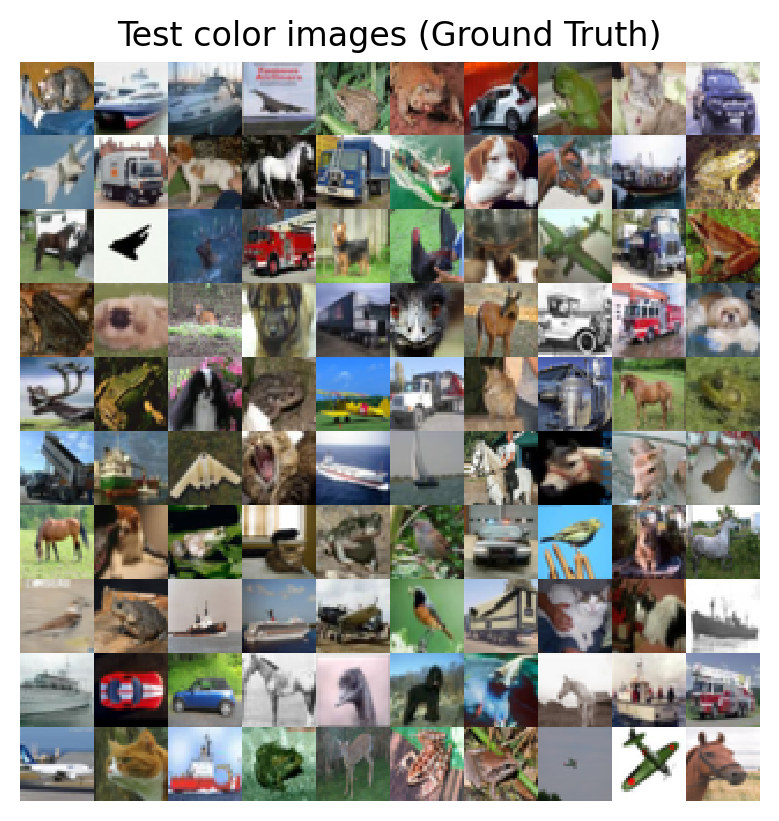

In [6]:
# Show input color images(100)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Test color images (Ground Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' %imgs_dir)
plt.show()

In [7]:
# Change Color to Gray_Scale
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

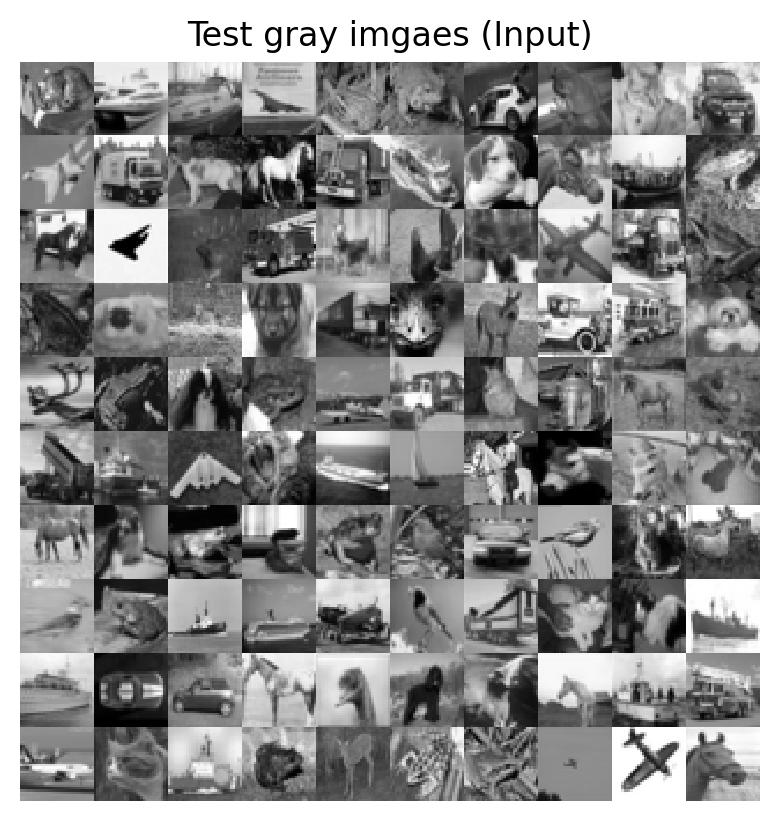

In [8]:
# Show input gray images(100)
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Test gray imgaes (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' %save_dir)
plt.show()

In [9]:
# Regularization
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

x_train_gray = x_train_gray.astype('float32')/255
x_test_gray = x_test_gray.astype('float32')/255

In [10]:
# Change image shape
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels) # Color Scale
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1) # Gray Scale
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [11]:
# Network Parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256

# Encoder & Decoder filters
layer_filters = [64, 128, 256]

In [12]:
from keras.layers import Conv2D, Flatten, Dense
from keras.layers import Conv2DTranspose, Reshape
from keras import backend as K

In [13]:
# Encoder Model
def encoder(inputs, layer_filters, latent_dim, kernel_size):
    x = inputs
    for filters in layer_filters:
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=2,
                   activation='relu',
                   padding='same'
                  )(x)
    shape = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latent_dim, name='latent_vector')(x)
    
    return latent, shape

In [14]:
inputs = keras.Input(shape=input_shape, name='encoder_input')
latent, shape = encoder(inputs, layer_filters, latent_dim, kernel_size)
encoder = keras.Model(inputs, latent, name='encoder')
encoder.summary()

Metal device set to: Apple M2
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Train

2023-02-11 15:16:51.168821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-11 15:16:51.169150: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
def decoder(latent_inputs, shape, layer_filters, kernel_size):
    x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs) # shape: (None, 4, 4, 256)
    x = Reshape((shape[1], shape[2], shape[3]))(x)
    
    for filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=2,
                            activation='relu',
                            padding='same',
                           )(x)
    outputs = Conv2DTranspose(filters=3,
                              kernel_size=kernel_size,
                              activation='sigmoid',
                              padding='same',
                              name='decoder_ouput'
                             )(x)
    return outputs

In [16]:
latent_inputs = keras.Input(shape=(latent_dim,), name='decoder_input')
outputs = decoder(latent_inputs, shape, layer_filters, kernel_size)
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 64)       7379

In [17]:
autoencoder = keras.Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Make Directory for saving models
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [19]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [20]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5, # 손실값이 5세대 내에 개선되지 않으면 학습속도를 sqrt(0.1) 감소시킴
                               verbose=1,
                               min_lr=0.5e-6
                              )

# Prepare callbacks for model saving and for learning rate adjustment
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                            )

In [21]:
autoencoder.compile(loss='mse', optimizer='adam')

In [22]:
callbacks = [lr_reducer, checkpoint]

In [23]:
autoencoder.fit(x_train_gray, x_train,
                validation_data=(x_test_gray, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks
               )

Epoch 1/30


2023-02-11 15:16:51.930733: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-11 15:16:52.189293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 0.0149

2023-02-11 15:17:26.174230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.01080, saving model to /Users/jaehwan/Desktop/Git/Artificial-Intelligence/DeepLearning/AutoEncoder/saved_models/colorized_ae_model.001.h5
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0149 - val_loss: 0.0108 - lr: 0.0010
Epoch 2/30
1562/1563 [============================>.] - ETA: 0s - loss: 0.0100
Epoch 2: val_loss improved from 0.01080 to 0.00940, saving model to /Users/jaehwan/Desktop/Git/Artificial-Intelligence/DeepLearning/AutoEncoder/saved_models/colorized_ae_model.002.h5
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0100 - val_loss: 0.0094 - lr: 0.0010
Epoch 3/30
1562/1563 [============================>.] - ETA: 0s - loss: 0.0090
Epoch 3: val_loss improved from 0.00940 to 0.00877, saving model to /Users/jaehwan/Desktop/Git/Artificial-Intelligence/DeepLearning/AutoEncoder/saved_models/colorized_ae_model.003.h5
1563/1563 [==============================] - 37s 24ms/step - loss: 0.0090 - val_loss

Epoch 30/30
1561/1563 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 30: val_loss did not improve from 0.00752
1563/1563 [==============================] - 47s 30ms/step - loss: 0.0038 - val_loss: 0.0078 - lr: 1.0000e-05


In [24]:
x_decoded = autoencoder.predict(x_test_gray)

2023-02-11 15:37:09.508472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


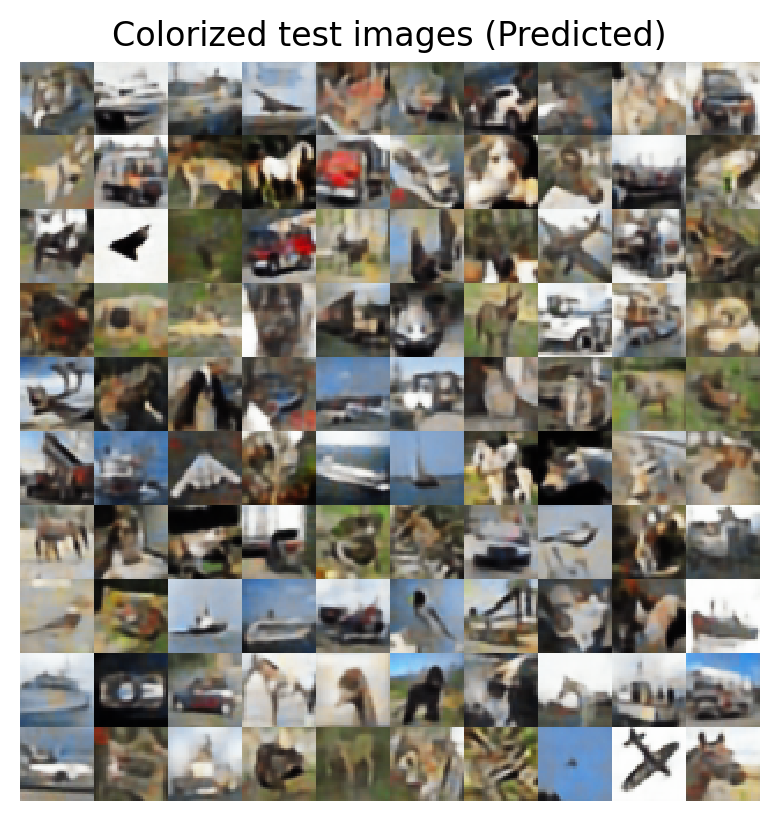

In [25]:
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' %imgs_dir)
plt.show()